In [1]:
%matplotlib inline

In [2]:
pwd

'/Users/jeremymobley/Desktop/cbb_modeling/Python'

In [3]:
from helper_functions import *

In [4]:
cd /Users/jeremymobley/Desktop/cbb_modeling/data/2018/

/Users/jeremymobley/Desktop/cbb_modeling/data/2018


In [5]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#### Load Data

In [6]:
teams = read_in_file_to_df("Teams")
tourney_compact_results = read_in_file_to_df("NCAATourneyCompactResults")
tourney_detailed_results = read_in_file_to_df("NCAATourneyDetailedResults")
reg_season_detailed_results = read_in_file_to_df("RegularSeasonDetailedResults")
reg_season_compact_results = read_in_file_to_df("RegularSeasonCompactResults")
sample_sub = read_in_file_to_df("SampleSubmissionStage1")
seasons = read_in_file_to_df("Seasons")

Teams (364, 4)
NCAATourneyCompactResults (2117, 8)
NCAATourneyDetailedResults (981, 34)
RegularSeasonDetailedResults (82041, 34)
RegularSeasonCompactResults (156089, 8)
SampleSubmissionStage1 (9112, 2)
Seasons (34, 6)


#### Combine regular season and tourney detailed results

In [7]:
all_detailed_results = pd.concat([reg_season_detailed_results, tourney_detailed_results])
print(all_detailed_results.shape)

(83022, 34)


### Calculate Advanced Metrics

#### Add in possession features

In [8]:
all_detailed_results = create_poss_fields(all_detailed_results)
all_detailed_results = create_ppp_fields(all_detailed_results)

#### Add advanced metrics
Takes a few seconds...

In [9]:
all_detailed_results = add_advanced_metrics(all_detailed_results)

#### Add in team names

In [10]:
all_detailed_results = add_in_team_names(all_detailed_results, teams)
print(all_detailed_results.shape)

(83022, 63)


#### Add in date from DayNum

In [11]:
all_detailed_results = add_in_date(all_detailed_results, seasons)
print(all_detailed_results.shape)

(83022, 64)


In [12]:
# Add in score_diff field
all_detailed_results['score_diff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']

## Create train data set

Train data set structure:  
* Result field is binary 0/1 representing if Team1 beats Team2
* Every game is represented by 2 different records

In [13]:
train = create_master_train(all_detailed_results)
print(train.shape)

(166044, 66)


In [14]:
# Create location variables
train['t1_Loc_H'] = [1 if loc=="H" else 0 for loc in train['t1_Loc']]
train['t1_Loc_N'] = [1 if loc=="N" else 0 for loc in train['t1_Loc']]

#### Add in Massey Ordinals

In [23]:
# Read in massey_ordinals file
#massey_ordinals = read_in_file_to_df("MasseyOrdinals")
massey_ordinals = read_in_file_to_df("MasseyOrdinals_thruSeason2018_Day128")
massey_ordinals_18 = read_in_file_to_df("MasseyOrdinals_2018_133_only_43Systems")
massey_ordinals.columns = ['Season', 'DayNum', 'SystemName', 'TeamID', 'OrdinalRank']
massey_ordinals_18.columns = ['Season', 'DayNum', 'SystemName', 'TeamID', 'OrdinalRank']
massey_ordinals = pd.concat([massey_ordinals, massey_ordinals_18])
print(massey_ordinals.shape)

MasseyOrdinals_thruSeason2018_Day128 (3470328, 5)
MasseyOrdinals_2018_133_only_43Systems (13854, 5)
(3484182, 5)


##### Look at Massey Ordinal data

In [374]:
# Look at most populated ranking systems
massey_ordinals[(massey_ordinals['DayNum']>50) & (massey_ordinals['Season']>2010)]['SystemName'].value_counts().head(10)

WLK    31043
DOK    31043
POM    31043
MOR    31043
SAG    31043
WIL    31042
PGH    31030
NOL    31011
KPK    30695
MAS    30695
Name: SystemName, dtype: int64

In [24]:
massey_rank_systems = ["WLK", "DOK", "POM", "MOR", "SAG", "WIL", "PGH", "NOL", "KPK", "MAS"]

In [25]:
for rnk_sys in massey_rank_systems:
    train = add_in_massey_ordinal_field(train, rnk_sys, massey_ordinals)

In [26]:
#train['t1_SAG_rnk_diff'] = train['t1_SAG_rnk'] - train['t2_SAG_rnk']
#train['t1_MAS_rnk_diff'] = train['t1_MAS_rnk'] - train['t2_MAS_rnk']

In [27]:
massey_ordinals[massey_ordinals['Season']==2018].groupby('DayNum').size()

DayNum
16      5315
23      5340
30      8148
37      9903
44     13062
51     14466
58     15519
65     16221
72     16572
79     18066
86     18417
93     21224
100    20874
107    21574
114    21575
121    21925
128    21926
133    13854
dtype: int64

## Look at all train records

In [29]:
HTML(train[(train['Season']==2018) & (train['t1_TeamID']==1207)].sort_values('DayNum').to_html())

,DayNum,NumOT,Result,Season,TotPoss,game_date,score_diff,t1_Ast,t1_AstR,t1_Blk,t1_DR,t1_DRP,t1_DefRtg,t1_FGA,t1_FGA3,t1_FGM,t1_FGM3,t1_FTA,t1_FTAR,t1_FTM,t1_Loc,t1_NetRtg,t1_OR,t1_ORP,t1_OffRtg,t1_PF,t1_PPP,t1_Poss,t1_RP,t1_Score,t1_Stl,t1_TO,t1_TOR,t1_TSP,t1_TeamID,t1_TeamName,t1_eFGP,t2_Ast,t2_AstR,t2_Blk,t2_DR,t2_DRP,t2_DefRtg,t2_FGA,t2_FGA3,t2_FGM,t2_FGM3,t2_FTA,t2_FTAR,t2_FTM,t2_NetRtg,t2_OR,t2_ORP,t2_OffRtg,t2_PF,t2_PPP,t2_Poss,t2_RP,t2_Score,t2_Stl,t2_TO,t2_TOR,t2_TSP,t2_TeamID,t2_TeamName,t2_eFGP,t1_Loc_H,t1_Loc_N,t1_WLK_rnk,t2_WLK_rnk,t1_WLK_rnk_diff,t1_DOK_rnk,t2_DOK_rnk,t1_DOK_rnk_diff,t1_POM_rnk,t2_POM_rnk,t1_POM_rnk_diff,t1_MOR_rnk,t2_MOR_rnk,t1_MOR_rnk_diff,t1_SAG_rnk,t2_SAG_rnk,t1_SAG_rnk_diff,t1_WIL_rnk,t2_WIL_rnk,t1_WIL_rnk_diff,t1_PGH_rnk,t2_PGH_rnk,t1_PGH_rnk_diff,t1_NOL_rnk,t2_NOL_rnk,t1_NOL_rnk_diff,t1_KPK_rnk,t2_KPK_rnk,t1_KPK_rnk_diff,t1_MAS_rnk,t2_MAS_rnk,t1_MAS_rnk_diff,t1_WLK_rnk,t2_WLK_rnk,t1_DOK_rnk,t2_DOK_rnk,t1_POM_rnk,t2_POM_rnk,t1_MOR_rnk,t2_MOR_rnk,t1_SAG_rnk,t2_SAG_rnk,t1_WIL_rnk,t2_WIL_rnk,t1_PGH_rnk,t2_PGH_rnk,t1_NOL_rnk,t2_NOL_rnk,t1_KPK_rnk,t2_KPK_rnk,t1_MAS_rnk,t2_MAS_rnk
6201,13,0,1.0,2018,144.050,2017-11-12,16.0,18,17.992803,7,26,0.634146,39.569594,57,26,26,10,16,0.280702,11,H,0.000000,11,0.333333,50.676848,20,1.013537,71.600,0.500000,73,9,18,11.261261,56.995628,1207,Georgetown,0.543860,11,11.261261,1,22,0.666667,50.676848,55,15,18,7,22,0.400000,14,-11.107254,15,0.365854,39.569594,19,0.791392,72.450,0.445946,57,4,22,11.261261,44.063080,1239,Jacksonville,0.390909,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9356,16,0,1.0,2018,152.200,2017-11-15,34.0,25,21.626298,4,37,0.840909,44.678055,68,22,39,11,15,0.220588,13,H,0.000000,14,0.466667,67.017083,17,1.340342,77.125,0.689189,102,5,16,14.662757,68.364611,1207,Georgetown,0.654412,14,14.662757,2,16,0.533333,67.017083,65,33,25,8,17,0.261538,10,-22.339028,7,0.159091,44.678055,17,0.893561,75.075,0.405405,68,7,9,14.662757,46.909492,1291,Mt St Mary's,0.446154,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13066,19,0,1.0,2018,139.050,2017-11-18,26.0,24,23.319083,5,37,0.822222,40.992449,58,19,30,9,18,0.310345,14,H,0.000000,11,0.379310,59.690759,17,1.193815,68.550,0.648649,83,2,13,13.363029,62.955097,1207,Georgetown,0.594828,12,13.363029,3,18,0.620690,59.690759,62,19,20,3,20,0.322581,14,-18.698310,8,0.177778,40.992449,15,0.819849,70.500,0.391892,57,6,7,13.363029,40.254237,1271,MD E Shore,0.346774,1,0,NaN,NaN,NaN,68.0,341.0,NaN,80.0,328.0,NaN,56.0,310.0,NaN,76.0,338.0,NaN,NaN,NaN,NaN,84.0,309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,328.0,NaN,NaN,NaN,68.0,341.0,80.0,328.0,56.0,310.0,76.0,338.0,NaN,NaN,84.0,309.0,NaN,NaN,NaN,NaN,63.0,328.0
25365,26,0,1.0,2018,136.475,2017-11-25,6.0,15,16.404199,2,26,0.722222,55.687855,47,18,25,10,26,0.553191,22,A,0.000000,9,0.346154,60.084265,15,1.201685,68.350,0.564516,82,5,18,13.392857,70.157426,1207,Georgetown,0.638298,12,13.392857,3,17,0.653846,60.084265,63,27,29,7,15,0.238095,11,-4.396410,10,0.277778,55.687855,18,1.113757,68.125,0.419355,76,9,8,13.392857,54.597701,1350,Richmond,0.515873,0,0,NaN,NaN,NaN,54.0,202.0,NaN,74.0,170.0,NaN,48.0,114.0,NaN,63.0,186.0,NaN,NaN,NaN,NaN,85.0,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,177.0,NaN,NaN,NaN,54.0,202.0,74.0,170.0,48.0,114.0,63.0,186.0,NaN,NaN,85.0,156.0,NaN,NaN,NaN,NaN,59.0,177.0
27902,29,0,1.0,2018,135.525,2017-11-28,21.0,13,14.167393,4,23,0.621622,40.582918,54,18,25,4,29,0.537037,22,H,0.000000,13,0.382353,56.078214,15,1.121564,66.775,0.507042,76,8,12,8.849558,56.920312,1207,Georgetown,0.500000,8,8.849558,5,21,0.617647,56.078214,60,23,22,4,10,0.166667,7,-15.495296,14,0.378378,40.582918,20,0.811658,68.750,0.478873,55,5,18,8.849558,42.701863,1263,Maine,0.400000,1,0,NaN,

---

## DEV

#### Add rolling features - working..

In [ ]:
def create_rolling_avg_feature(df, field_to_agg, num_games=5):
    df = df.sort_values(['t1_TeamID', 'Season','DayNum']).reset_index()
    col_name = field_to_agg + "_rolling_avg_" + str(num_games) + "gm"
    df[col_name] = df.groupby(['Season', 't1_TeamID'])[[field_to_agg]].shift(1) \
        .rolling(window=num_games, min_periods=num_games).mean()
    return df

In [92]:
train = train.sort_values(['t1_TeamID', 'Season','DayNum']).reset_index()

ValueError: cannot insert level_0, already exists

In [68]:
train['t1_offPPP_rolling_avg_5gm'] = train.groupby(['Season', 't1_TeamID'])[['t1_PPP']].shift(1) \
        .rolling(window=5, min_periods=5).mean()

In [67]:
train['t1_defPPP_rolling_avg_5gm'] = train.groupby(['Season', 't1_TeamID'])[['t2_PPP']].shift(1) \
        .rolling(window=5, min_periods=5).mean()

In [95]:
train['t1_offPPP_ssn_avg'] = train.groupby(['Season', 't1_TeamID'])[['t1_PPP']].shift(1) \
        .rolling(window=20, min_periods=15).mean()

In [14]:
train = create_rolling_avg_feature(train, "t1_PPP", num_games=5)
train = create_rolling_avg_feature(train, "t2_PPP", num_games=5)

In [70]:
num_games = 5
#train = train.sort_values(['t1_TeamID', 'Season','DayNum']).reset_index()
agg_funcs = {'t1_PPP':['mean', 'max'], 't2_PPP':['mean']}
train_metrics_agg = train.groupby(['Season', 't1_TeamID']).shift(1) \
    .rolling(window=num_games, min_periods=num_games).agg(agg_funcs)

In [74]:
train_metrics_agg.columns = ['t1_PPP_mean', 't1_PPP_max', 't2_PPP_mean']
train_metrics_agg.shape

In [75]:
train_metrics_agg.head(10)

,t1_PPP_mean,t1_PPP_max,t2_PPP_mean
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,0.806336,1.004315,1.218981
6,0.804361,1.004315,1.250998
7,0.807975,1.004315,1.253397
8,0.879251,1.043478,1.268299
9,0.947804,1.043478,1.179179


### Loop through train to create features

In [198]:
# create 2017 df for dev
train_17 = train[train['Season']==2017].copy().reset_index(drop=True).sort_values(['DayNum'])
train_17['t1_off_ssn_avg_PPP'] = 0
print(train_17.shape)

(10924, 104)


In [192]:
# create ongoing aggregates for season
season_TeamIDs = train_17['t1_TeamID'].drop_duplicates().tolist()
season_totals = pd.DataFrame()
season_totals['t1_TeamID'] = season_TeamIDs
season_totals['games_played'] = 0
season_totals['t1_off_ssn_avg_PPP'] = 0
#season_totals['t1_def_ssn_avg_PPP'] = 0
# loop through each record in train_17
for idx, row in train_17.iterrows():
    if idx % 1000 == 0 :
        print(idx,end=': ')

    t1 = row['t1_TeamID']
    t1_game_PPP = row['t1_PPP']
    t1_gp = season_totals.loc[season_totals['t1_TeamID']==t1, 'games_played']
    t1_ssn_avg_PPP = season_totals.loc[season_totals['t1_TeamID']==t1, 't1_off_ssn_avg_PPP']
    
    # update train_17
    train_17.loc[idx,'t1_off_ssn_avg_PPP'] = t1_ssn_avg_PPP
    
    # update season_totals
    season_totals.loc[season_totals['t1_TeamID']==t1,'t1_off_ssn_avg_PPP'] = ((t1_ssn_avg_PPP * t1_gp) + t1_game_PPP)/ (t1_gp + 1.0)
    season_totals.loc[season_totals['t1_TeamID']==t1,'games_played'] += 1
    

ValueError: Incompatible indexer with Series

In [211]:
train_17[['t1_TeamID', 't1_PPP', 'DayNum']].head()

,t1_TeamID,t1_PPP,DayNum
6909,1334,0.995644,11
467,1117,0.922593,11
1455,1154,0.840154,11
2549,1190,1.383285,11
8365,1381,0.935420,11


In [215]:
# create ongoing aggregates for season
season_TeamIDs = train_17['t1_TeamID'].drop_duplicates().tolist()
season_totals = pd.DataFrame()
season_totals['t1_TeamID'] = season_TeamIDs
season_totals['games_played'] = 0
season_totals['t1_off_ssn_avg_PPP'] = 0
#season_totals['t1_def_ssn_avg_PPP'] = 0
# loop through each record in train_17
for i, row in enumerate(train_17[['t1_TeamID', 't1_PPP']][0:50].itertuples(index=False), 1):
    #if itrtup[0] % 1000 == 0 :
        #print(itrtup[0],end=': ')
    
    print(i)

    t1 = row[0]
    print(t1)
    t1_game_PPP = row[1]
    print(t1_game_PPP,end=', ')
    t1_gp = season_totals.loc[season_totals['t1_TeamID']==t1, 'games_played']
    print(t1_gp,end=', ')
    t1_ssn_avg_PPP = season_totals.loc[season_totals['t1_TeamID']==t1, 't1_off_ssn_avg_PPP']
    
    # update train_17
    #train_17.loc[itrtup[0],'t1_off_ssn_avg_PPP'] = t1_ssn_avg_PPP
    train_17.set_value(i, 't1_off_ssn_avg_PPP', t1_ssn_avg_PPP)
    
    # update season_totals
    season_totals.loc[season_totals['t1_TeamID']==t1,'t1_off_ssn_avg_PPP'] = ((t1_ssn_avg_PPP * t1_gp) + t1_game_PPP)/ (t1_gp + 1.0)
    season_totals.loc[season_totals['t1_TeamID']==t1,'games_played'] += 1
    

1
1334
0.9956440572495333, 0    0
Name: games_played, dtype: int64, 2
1117
0.9225930456054517, 1    0
Name: games_played, dtype: int64, 3
1154
0.8401544401544402, 2    0
Name: games_played, dtype: int64, 4
1190
1.3832853025936598, 3    0
Name: games_played, dtype: int64, 5
1381
0.935420039575463, 4    0
Name: games_played, dtype: int64, 6
1210
1.09204368174727, 5    0
Name: games_played, dtype: int64, 7
1284
1.075491209927611, 6    0
Name: games_played, dtype: int64, 8
1182
0.9027777777777778, 7    0
Name: games_played, dtype: int64, 9
1173
1.3146182814104757, 8    0
Name: games_played, dtype: int64, 10
1285
0.8887270078309963, 9    0
Name: games_played, dtype: int64, 11
1155
1.0977192657148156, 10    0
Name: games_played, dtype: int64, 12
1286
0.8910212474297464, 11    0
Name: games_played, dtype: int64, 13
1378
1.1123986095017382, 12    0
Name: games_played, dtype: int64, 14
1350
1.0024364775495997, 13    0
Name: games_played, dtype: int64, 15
1208
0.9493788244020027, 14    0
Name: g

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


28
1158
1.0007722007722009, 27    0
Name: games_played, dtype: int64, 29
1283
1.512108682811577, 28    0
Name: games_played, dtype: int64, 30
1282
1.0484257631452771, 29    0
Name: games_played, dtype: int64, 31
1119
0.9560763619431942, 30    0
Name: games_played, dtype: int64, 32
1392
0.991363124295907, 31    0
Name: games_played, dtype: int64, 33
1148
1.0190217391304348, 32    0
Name: games_played, dtype: int64, 34
1345
1.3756112951569648, 33    0
Name: games_played, dtype: int64, 35
1105
0.9765701909824769, 34    0
Name: games_played, dtype: int64, 36
1390
1.0548870941157078, 35    0
Name: games_played, dtype: int64, 37
1216
0.8152173913043479, 36    0
Name: games_played, dtype: int64, 38
1276
1.1681075888568684, 37    0
Name: games_played, dtype: int64, 39
1435
0.9060456213112139, 38    0
Name: games_played, dtype: int64, 40
1214
0.766335956209374, 39    0
Name: games_played, dtype: int64, 41
1277
0.932642487046632, 40    0
Name: games_played, dtype: int64, 42
1388
1.37843012125079

In [141]:
season_totals.head()

,t1_TeamID,games_played,t1_off_ssn_avg_PPP,t1_def_ssn_avg_PPP
0,1101,25,0,0
1,1102,31,0,0
2,1103,33,0,0
3,1104,33,0,0
4,1105,29,0,0


In [160]:
train_17.loc[idx,'t1_off_ssn_avg_PPP']

0.0

# Modeling

---

### Create modeling df

In [19]:
all_modeling_fields = ["t1_MAS_rnk_diff",
                       "t1_WLK_rnk_diff",
                       "t1_DOK_rnk_diff", 
                       "t1_POM_rnk_diff", 
                       "t1_MOR_rnk_diff", 
                       "t1_SAG_rnk_diff", 
                       "t1_Loc_N", 
                       "t1_Loc_H"]

In [33]:
model_train_df = shuffle(train.copy())
print(model_train_df.shape)
model_train_df = model_train_df[model_train_df['DayNum'] > 80]
model_train_df = model_train_df[model_train_df['DayNum'] < 130]
model_train_df = model_train_df.dropna(subset=all_modeling_fields)
print(model_train_df.shape)

(155234, 98)
(35566, 98)


### Create test games df

In [34]:
model_test_df = train.copy()
model_test_df = model_test_df[model_test_df['DayNum'] > 130]
model_test_df = model_test_df.dropna(subset=all_modeling_fields)
print(model_test_df.shape)

(1514, 98)


Predict 0/1 winner

### Logistic

In [35]:
logistic = linear_model.LogisticRegression()

In [36]:
#logistic_model_fields = ['t1_SAG_rnk', 't2_SAG_rnk', "t1_MAS_rnk", "t2_MAS_rnk", "t1_Loc_H"]
#logistic_model_fields = ['t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk", "t1_Loc_H"]
#logistic_model_fields = ['t1_SAG_rnk', 't2_SAG_rnk', "t1_MAS_rnk", "t2_MAS_rnk"]
logistic_model_fields = ['t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk"]

In [37]:
# Fit model
logistic.fit(model_train_df[logistic_model_fields], 
             model_train_df['Result'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
# Create preds
preds = logistic.predict_proba(model_test_df[logistic_model_fields])[:, 1]
print(calc_logloss(preds, model_test_df['Result']))

0.5955024485708567


### GBM

In [39]:
gbm_model_fields = [
    #"t1_SAG_rnk", "t2_SAG_rnk", 
    #"t1_MAS_rnk", "t2_MAS_rnk", 
    "t1_MAS_rnk_diff",
    "t1_WLK_rnk_diff",
    "t1_DOK_rnk_diff",
    "t1_POM_rnk_diff",
    "t1_MOR_rnk_diff",
    "t1_SAG_rnk_diff",
    "t1_Loc_H",
    "t1_Loc_N"
]

In [40]:
gbm = GradientBoostingClassifier(n_estimators=20, 
                                max_depth=4, 
                                 max_features=3,
                                learning_rate=0.06)

In [41]:
gbm.fit(model_train_df[gbm_model_fields], model_train_df['Result'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.06, loss='deviance', max_depth=4,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [42]:
# create preds
preds = gbm.predict_proba(model_test_df[gbm_model_fields])[:, 1]
print(calc_logloss(preds, model_test_df['Result']))

0.6091879970916263


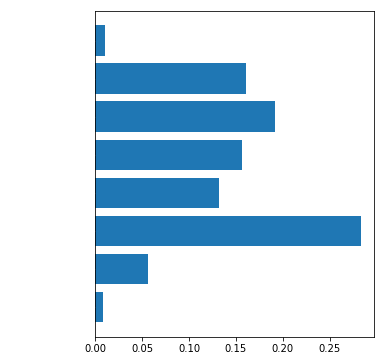

In [43]:
# Feature Importances
importances = gbm.feature_importances_
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(range(len(importances)), importances)
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(gbm_model_fields)
plt.yticks(range(len(importances)), gbm_model_fields)
plt.show()

#### Tune GBM parameters

In [59]:
param_grid = {
        'n_estimators': [20,40,60],
        'max_depth': [3,4,6],
        'max_features': [3],
        'learning_rate': [0.10, 0.12, 0.14]
    }

gbm = GradientBoostingClassifier(random_state=0)

estimator = GridSearchCV(gbm,
                         param_grid, 
                         scoring='neg_log_loss',
                         n_jobs=-1)

In [60]:
# fit model
estimator.fit(model_train_df[logistic_model_fields], model_train_df['Result'])

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [20, 40, 60], 'max_depth': [3, 4, 6], 'max_features': [3], 'learning_rate': [0.1, 0.12, 0.14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [61]:
preds = estimator.predict_proba(model_test_df[logistic_model_fields])[:, 1]
print(calc_logloss(preds, model_test_df['Result']))

0.5758802578604997


In [62]:
# Look at best parameter set
print(estimator.best_params_)
print(estimator.best_score_)

{'learning_rate': 0.12, 'max_depth': 3, 'max_features': 3, 'n_estimators': 60}
-0.5756930111466861


### Feature Selection

In [188]:
importances = feature_selection.f_classif(model_train_df[logistic_model_fields], model_train_df['Result'])

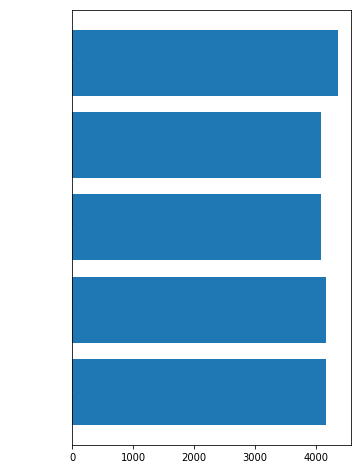

In [189]:
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(range(len(importances[0])), importances[0])
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(logistic_model_fields)
plt.yticks(range(len(importances[0])), logistic_model_fields)
plt.show()

## Modeling - predict point spread
* Predict point spread directly -> convert to win probability
* Predict possessions, ppp -> convert to final score -> convert to win probability

In [52]:
gbm = GradientBoostingRegressor(n_estimators=40, 
                                max_depth=4, 
                                 max_features=3,
                                learning_rate=0.10)

In [53]:
gbm.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [54]:
# create preds
preds = gbm.predict(model_test_df[gbm_model_fields])
preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in preds])

In [55]:
print(calc_logloss(preds, model_test_df['Result']))

0.5849152332064722


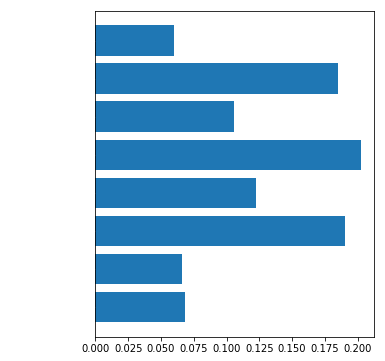

In [56]:
# Feature Importances
importances = gbm.feature_importances_
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(range(len(importances)), importances)
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(gbm_model_fields)
plt.yticks(range(len(importances)), gbm_model_fields)
plt.show()

In [57]:
param_grid = {
        'n_estimators': [20,40],
        'max_depth': [4,5,6],
        'max_features': [3],
        'learning_rate': [0.08, 0.10, 0.15]
    }

gbm = GradientBoostingRegressor(random_state=0)

estimator = GridSearchCV(gbm,
                         param_grid, 
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

In [58]:
# fit model
estimator.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])

# Look at best parameter set
print(estimator.best_params_)
print(estimator.best_score_)

# create preds
preds = estimator.predict(model_test_df[gbm_model_fields])
preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in preds])
print(calc_logloss(preds, model_test_df['Result']))

{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 3, 'n_estimators': 40}
-113.96500036877347
0.5842627142112337


### Create 2018 preds

In [31]:
model_test_df = train.copy()
model_test_df = model_test_df[(model_test_df['DayNum'] > 130) & (model_test_df['Season']== 2018)]
print(model_test_df.shape)

(58, 118)
